The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


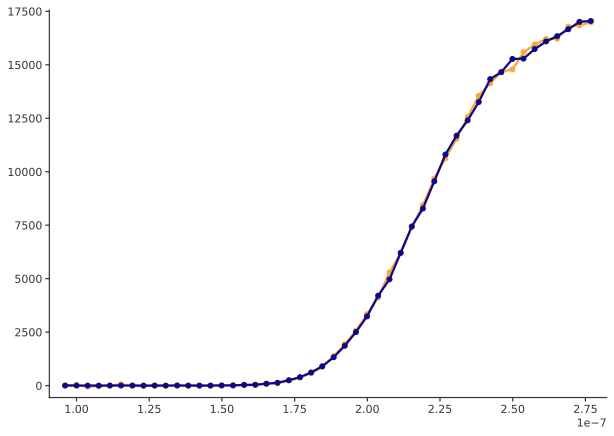

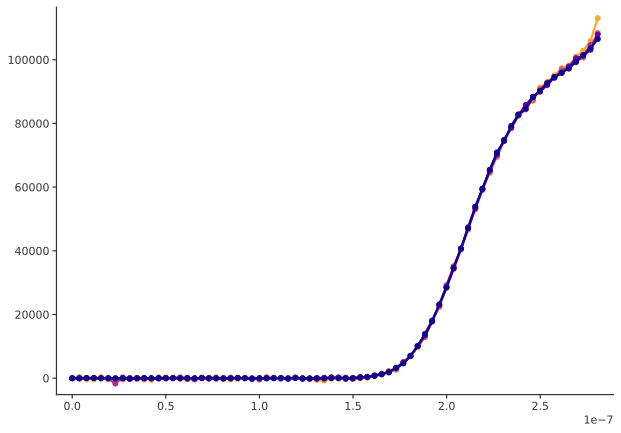

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
import re
from dataclasses import dataclass
from typing import Optional, Tuple, List
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from snsphd.viz import phd_style

from snsphd.layout import bisect

colors, swatches = phd_style(jupyterStyle=True)

@dataclass
class PixelData:
    """Data structure for a single pixel's PCR measurements."""
    bias_current: np.ndarray
    counts: np.ndarray
    dark_counts: np.ndarray
    pixel_id: str
    filename: str
    
    def get_scaled_bias_current(self, scale_factor: float = 1020000) -> np.ndarray:
        """Get bias current scaled by the given factor."""
        return self.bias_current / scale_factor

@dataclass
class PlotConfig:
    """Configuration for plotting PCR data."""
    cut_start_points: int = 0
    cut_end_points: int = 0
    filter_index: Optional[int] = None
    color: Optional[str] = None
    label: Optional[str] = None
    scale_factor: float = 1.0
    title: Optional[str] = None
    marker_size: float = 5.0
    save_plot: bool = False
    show_plot: bool = True

class PCRDataLoader:
    """Loads and parses PCR data from CSV files into PixelData objects."""
    
    def __init__(self, filepath: str):
        self.filepath = filepath
        self.data = pd.read_csv(filepath)
        self.x_col = self.data.columns[0]
        self.count_cols = sorted([col for col in self.data.columns if col.startswith("Counts_TL")])
        self.dcount_cols = sorted([col for col in self.data.columns if col.startswith("DCounts_TL")])
        self.col_pairs = self._create_column_pairs()
    
    def _create_column_pairs(self) -> dict:
        """Create pairs of count and dark count columns."""
        col_pairs = {}
        for c_col in self.count_cols:
            match = re.match(r"Counts_(.*)", c_col)
            if match:
                identifier = match.group(1)
                d_col_expected = f"DCounts_{identifier}"
                if d_col_expected in self.dcount_cols:
                    col_pairs[identifier] = {"count": c_col, "dcount": d_col_expected}
        return col_pairs
    
    def get_pixel_data(self, pixel_index: int) -> PixelData:
        """Get PixelData for a specific pixel by index."""
        if pixel_index >= len(self.col_pairs):
            raise IndexError(f"Pixel index {pixel_index} out of range. Available pixels: {len(self.col_pairs)}")
        
        pixel_id = list(self.col_pairs.keys())[pixel_index]
        cols = self.col_pairs[pixel_id]
        
        return PixelData(
            bias_current=self.data[self.x_col].values,
            counts=self.data[cols["count"]].values,
            dark_counts=self.data[cols["dcount"]].values,
            pixel_id=pixel_id,
            filename=self.filepath.split("/")[-1]
        )
    
    def get_all_pixels(self) -> List[PixelData]:
        """Get PixelData for all pixels in the file."""
        return [self.get_pixel_data(i) for i in range(len(self.col_pairs))]
    
    def get_pixel_count(self) -> int:
        """Get the number of pixels in the data file."""
        return len(self.col_pairs)

class PCRDataPlotter:
    """Handles PCR data plotting with clean separation of concerns."""
    
    def __init__(self, csv_data: str):
        self.data = pd.read_csv(io.StringIO(csv_data))
        self.x_col = self.data.columns[0]
        self.count_cols = sorted([col for col in self.data.columns if col.startswith("Counts_TL")])
        self.dcount_cols = sorted([col for col in self.data.columns if col.startswith("DCounts_TL")])
        self.col_pairs = self._create_column_pairs()
    
    def _create_column_pairs(self) -> dict:
        """Create pairs of count and dark count columns."""
        col_pairs = {}
        for c_col in self.count_cols:
            match = re.match(r"Counts_(.*)", c_col)
            if match:
                identifier = match.group(1)
                d_col_expected = f"DCounts_{identifier}"
                if d_col_expected in self.dcount_cols:
                    col_pairs[identifier] = {"count": c_col, "dcount": d_col_expected}
        return col_pairs
    
    def plot_on_axes(self, ax: Axes, config: PlotConfig) -> None:
        """Plot data on provided axes with given configuration."""
        if config.filter_index is not None:
            self._plot_single_pair(ax, config)
        else:
            self._plot_all_pairs(ax, config)
        
        # self._configure_axes(ax, config)
    
    def _plot_single_pair(self, ax: Axes, config: PlotConfig) -> None:
        """Plot a single count/dark count pair."""
        if config.filter_index >= len(self.col_pairs):
            return
            
        identifier = list(self.col_pairs.keys())[config.filter_index]
        cols = self.col_pairs[identifier]
        
        # Fix color handling - check if config.color is None instead of using 'or'
        color = config.color if config.color is not None else plt.cm.plasma(0.5)
        label = config.label or cols["count"]
        
        self._plot_pair(ax, cols, color, label, config)
    
    def _plot_all_pairs(self, ax: Axes, config: PlotConfig) -> None:
        """Plot all count/dark count pairs."""
        colors = plt.cm.plasma(np.linspace(0.8, 0, len(self.col_pairs)))
        
        for i, (identifier, cols) in enumerate(self.col_pairs.items()):
            color = colors[i]
            label = cols["count"]
            self._plot_pair(ax, cols, color, label, config)
    
    def _plot_pair(self, ax: Axes, cols: dict, color: str, label: str, config: PlotConfig) -> None:
        """Plot a single count/dark count pair with given styling."""
        cut = config.cut_end_points
        x_data = self.data[self.x_col][:-cut] / 1020000 if cut > 0 else self.data[self.x_col] / 1020000
        
        # Plot counts
        ax.plot(
            x_data,
            self.data[cols["count"]][:-cut] * config.scale_factor if cut > 0 else self.data[cols["count"]] * config.scale_factor,
            marker="o",
            linestyle="-",
            label=label,
            color=color,
            markersize=config.marker_size,
        )
        
        # # Plot dark counts
        # ax.plot(
        #     x_data,
        #     self.data[cols["dcount"]][:-cut] if cut > 0 else self.data[cols["dcount"]],
        #     marker="x",
        #     linestyle="--",
        #     label=f"{label} DCR",
        #     color=color,
        #     markersize=config.marker_size,
        # )
    
    def _configure_axes(self, ax: Axes, config: PlotConfig) -> None:
        """Configure axes labels, title, legend, etc."""
        ax.set_xlabel("Bias Current (A)")
        ax.set_ylabel("Counts per second (Hz)")
        ax.grid(True)
        ax.legend(fontsize=13, frameon=False, ncol=2)
        
        if config.title:
            ax.set_title(config.title, fontsize=11, fontweight="bold")

class PCRPlotManager:
    """High-level manager for creating and managing PCR plots."""
    
    def __init__(self):
        self.fig: Optional[Figure] = None
        self.ax: Optional[Axes] = None
    
    def create_figure(self, figsize: Tuple[float, float] = (10, 7)) -> 'PCRPlotManager':
        """Create a new figure and axes."""
        self.fig, self.ax = plt.subplots(1, 1, figsize=figsize)
        return self
    
    def use_axes(self, fig: Figure, ax: Axes) -> 'PCRPlotManager':
        """Use existing figure and axes."""
        self.fig, self.ax = fig, ax
        return self
    
    def add_file_data(self, filepath: str, config: PlotConfig) -> 'PCRPlotManager':
        """Add data from a file to the current plot."""
        if self.ax is None:
            self.create_figure()
        
        with open(filepath, "r") as file:
            csv_data = file.read()
        
        plotter = PCRDataPlotter(csv_data)
        plotter.plot_on_axes(self.ax, config)
        return self
    
    def add_pixel_data(self, pixel_data: PixelData, config: PlotConfig, ax: None | Axes = None) -> 'PCRPlotManager':
        """Add PixelData to the current plot."""
        if self.ax is None:
            self.create_figure()
        
        self._plot_pixel_data(pixel_data, config, ax=ax or self.ax)
        return self
    
    def _plot_pixel_data(self, pixel_data: PixelData, config: PlotConfig, ax = None) -> None:
        """Plot a single PixelData object."""
        cut = config.cut_end_points
        cut_start = config.cut_start_points
        x_data = pixel_data.get_scaled_bias_current()
        
        if cut > 0:
            x_data = x_data[cut_start:-cut]
            counts = pixel_data.counts[cut_start:-cut]
            dark_counts = pixel_data.dark_counts[cut_start:-cut]
        else:
            counts = pixel_data.counts
            dark_counts = pixel_data.dark_counts
        
        color = config.color if config.color is not None else plt.cm.plasma(0.5)
        label = config.label or pixel_data.pixel_id
        
        # Plot counts
        (ax or self.ax).plot(
            x_data,
            counts * config.scale_factor,
            marker="o",
            linestyle="-",
            label=label,
            color=color,
            markersize=config.marker_size,
        )
        
        # Plot dark counts
        # self.ax.plot(
        #     x_data,
        #     dark_counts,
        #     marker="x",
        #     linestyle="--",
        #     label=f"{label} DCR",
        #     color=color,
        #     markersize=config.marker_size,
        # )
        
        # Configure axes
        self.ax.set_xlabel("Bias Current (A)")
        self.ax.set_ylabel("Counts per second (HZ)")
        self.ax.grid(True)
        self.ax.legend(fontsize=13, frameon=False, ncol=2)
        
        if config.title:
            self.ax.set_title(config.title, fontsize=11, fontweight="bold")
    
    def save_and_show(self, filename: Optional[str] = None, dpi: int = 300) -> None:
        """Save and/or show the plot."""
        if filename:
            plt.savefig(filename, dpi=dpi, bbox_inches="tight")
        plt.show()
    
    def get_figure(self) -> Tuple[Figure, Axes]:
        """Get the current figure and axes."""
        return self.fig, self.ax

# Example usage with much cleaner API:
def plot_single_file(filepath: str, config: PlotConfig) -> None:
    """Simple function to plot a single file."""
    PCRPlotManager().create_figure().add_file_data(filepath, config).save_and_show()

# Updated simple plotting function
def file_to_graph(path: str, cut_end_points: int = 0, title: str = None):
    """Simple function for single file plotting."""
    config = PlotConfig(
        cut_end_points=cut_end_points,
        title=title or path.split("/")[-1],
        save_plot=True,
        show_plot=True
    )
    plot_single_file(path, config)

# Examples
file_to_graph(
    "../data/Antenna/stable_setting_20ohm_shunts_1.0Thermal/6_All_Constrictions_80nm_2snap_1.0Thermal_265mK_start_XXX_stop.csv",
    8,
    title="80nm_2snap_1.0Thermal",
)

file_to_graph(
    "../data/Antenna/stable_settings_20ohm_shunts/5_80nm_2snap_Meander_1.0Thermal_258mK_start_XXX_stop.csv",
    2,
    title="80nm_2snap_Meander_1.0Thermal",
)

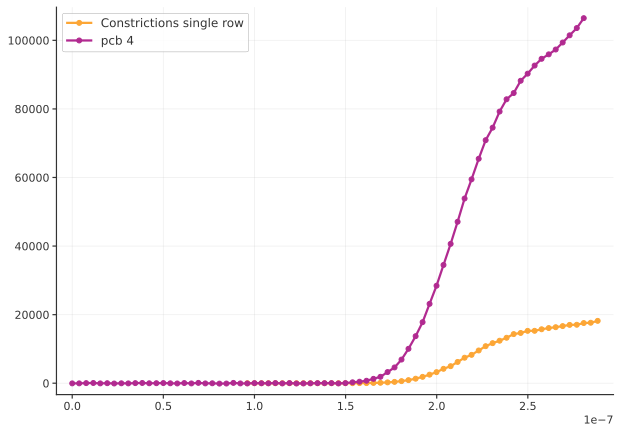

In [13]:
# Much cleaner multi-file plotting
colors = plt.cm.plasma(np.linspace(0.8, 0, 3))

manager = PCRPlotManager().create_figure()

# Add each file with clear, readable configuration
manager.add_file_data(
    "../data/Antenna/stable_setting_20ohm_shunts_1.0Thermal/6_All_Constrictions_80nm_2snap_1.0Thermal_265mK_start_XXX_stop.csv",
    PlotConfig(cut_start_points=10, cut_end_points=5, filter_index=1, color=colors[0], label="Constrictions single row")
)

manager.add_file_data(
    "../data/Antenna/stable_settings_20ohm_shunts/5_80nm_2snap_Meander_1.0Thermal_258mK_start_XXX_stop.csv",
    PlotConfig(cut_start_points=10, cut_end_points=2, filter_index=4, color=colors[1], label="pcb 4")
)

# manager.add_file_data(
#     "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb5_44.38M_1.61TVS1_0.080_0.090_0.100V_258mK.csv",
#     PlotConfig(cut_end_points=13, filter_index=1, color=colors[2], label="pcb 5")
# )

# manager.add_file_data(
#     "../data/R1C3_cryoamp_6.23.2025/R1C3_pcb7_44.38M_1.61TVS1_0.080_0.090_0.100V_263mK.csv",
#     PlotConfig(cut_end_points=13, filter_index=1, color=colors[3], label="pcb 7", title="4 pixel 1x1mm array, 6.23.2025")
# )

manager.ax.grid()
manager.ax.legend()

manager.save_and_show("../data/constriction_with_without_meander.svg")

In [14]:
# New approach: Load pixel data separately using PCRDataLoader
# This gives us clean separation between data loading and plotting

# Define file paths
file_paths = [
    "../data/Antenna/stable_setting_20ohm_shunts_1.0Thermal/6_All_Constrictions_80nm_2snap_1.0Thermal_265mK_start_XXX_stop.csv",
    "../data/Antenna/stable_settings_20ohm_shunts/5_80nm_2snap_Meander_1.0Thermal_258mK_start_XXX_stop.csv",
]

# Load data for each PCB and extract specific pixels
pcb_data_loaders = [PCRDataLoader(path) for path in file_paths]

# Get pixel data for each PCB (assuming we want pixel index 1 for PCB4 and index 2 for PCB1)
pixel_configs = [
    {"loader": pcb_data_loaders[0], "pixel_index": 1, "cut_end_points": 5, "cut_start_points": 10, "label": "80 nm 8 constrictions (single row)"},
    {"loader": pcb_data_loaders[1], "pixel_index": 4, "cut_end_points": 2, "cut_start_points": 10, "label": "80 nm 64 constrictions (meander)"},
]

# Extract pixel data
pixel_data_list: list[PixelData] = []
for config in pixel_configs:
    pixel_data: PixelData = config["loader"].get_pixel_data(config["pixel_index"])
    pixel_data_list.append((pixel_data, config))

# Display info about loaded pixels
for pixel_data, config in pixel_data_list:
    print(f"{config['label']}: {pixel_data.pixel_id} from {pixel_data.filename}")
    print(f"  Bias current range: {pixel_data.get_scaled_bias_current()[0]:.6f} to {pixel_data.get_scaled_bias_current()[-1]:.6f} A")
    print(f"  Counts range: {pixel_data.counts.min():.1f} to {pixel_data.counts.max():.1f} Hz")
    print(f"  Dark counts range: {pixel_data.dark_counts.min():.1f} to {pixel_data.dark_counts.max():.1f} Hz")
    print()

80 nm 8 constrictions (single row): TL2(0.040) from 6_All_Constrictions_80nm_2snap_1.0Thermal_265mK_start_XXX_stop.csv
  Bias current range: 0.000000 to 0.000000 A
  Counts range: -1.5 to 230933.1 Hz
  Dark counts range: 0.0 to 1720384.5 Hz

80 nm 64 constrictions (meander): TL5(0.014) from 5_80nm_2snap_Meander_1.0Thermal_258mK_start_XXX_stop.csv
  Bias current range: 0.000000 to 0.000000 A
  Counts range: -304694.3 to 106466.2 Hz
  Dark counts range: 73.0 to 1252805.0 Hz



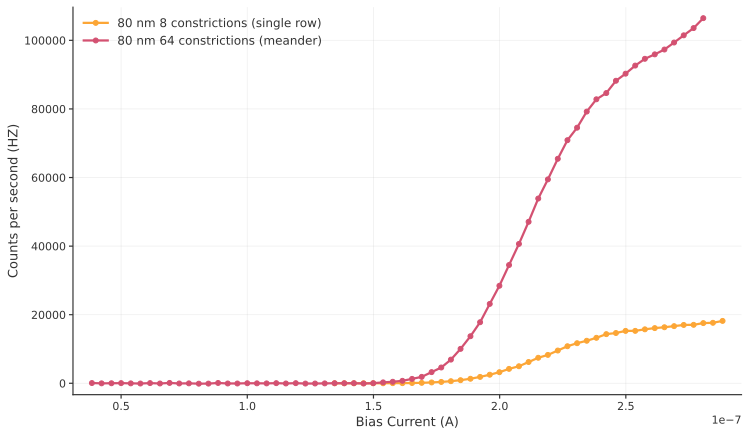

<Figure size 3000x1250 with 0 Axes>

In [15]:
colors = plt.cm.plasma(np.linspace(0.8, 0, 4))
manager = PCRPlotManager().create_figure(figsize=(12, 7))
fig = plt.figure(figsize=(12, 5))

for i, (pixel_data, config) in enumerate(pixel_data_list):
    plot_config = PlotConfig(
        cut_start_points=config["cut_start_points"],
        cut_end_points=config["cut_end_points"],
        color=colors[i],
        label=config["label"],
        marker_size=5.0
    )
    manager.add_pixel_data(pixel_data, plot_config)
# manager.add_pixel_data(pixel_data, plot_config, ax=ax_bottom if i % 2 == 0 else ax_top)
manager.ax.legend(loc="upper left", frameon = False)
